##### **Warning**
- Maxwell filtering was originally developed for Elekta Neuromag systems, and should be considered experimental for non-Neuromag data.

MNE-python中实现的SSS/Maxwell filtering 提供了如下功能：
- Bad channel reconstruction
- Cross-talk cancellation
- Fine calibration correction
- tSSS
- Coordinate frame translation
- Regularization of internal components using information theory
- Raw movement compensation (using head position estimated by MaxFilter)
- cHPI subtraction 
- Handling of 3D (in addition to 1D) fine calibration files
- Epoch-based movement compensation


In [ ]:
import os
import mne

In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_folder

'/Users/reallo/mne_data/MNE-sample-data'

In [4]:
sample_data_raw_file = os.path.join(sample_data_folder,'MEG','sample','sample_audvis_raw.fif')

In [6]:
raw = mne.io.read_raw_fif(sample_data_raw_file,verbose=False)
raw.crop(tmax=60).load_data()

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 36038 (60.0 sec), ~107.0 MB, data loaded>

In [8]:
raw.plot()

<Figure size 640x480 with 5 Axes>

<Figure size 640x480 with 5 Axes>

- Maxwell filtering is a related procedure that omits the higher-order
componets of the internal subspace, which are dominated by sensor noise. Typically, Maxwell filtering and SSS are performed together in MNE-Python.
- Signal-space separation(SSS) is a technique based on the physics of electromagnetic fileds. SSS separates the measured signal into components attributable to sources inside the measurement volume of the sensor array(the internal components), and components attributable to sources outside the measurement volume(the external components).

在使用SSS处理Eleka采集的数据时，需要下述文件：
- fine calibration file，里面包含了传感器方向和校准信息
- crosstalk compensation file，用于减少Elekta的同位磁力计和成对的梯度计传感器单元之间的干扰。


In [9]:
fine_cal_file = os.path.join(sample_data_folder,'SSS','sss_cal_mgh.dat')
crosstalk_file = os.path.join(sample_data_folder,'SSS','ct_sparse_mgh.fif')

在我们使用SSS之前，需要设置几个bad channels。比如MEG 2313通道有一些直流跳跃（DC jumps），MEG 1032 有一些较大的低频漂移。然后我们在提供了crosstalk和fine calibration文件之后，调用`maxwell_filter()`函数，即可完成SSS和Maxwell过滤。

In [10]:
raw.info['bads'].extend(['MEG 1032','MEG 2323'])
raw_sss = mne.preprocessing.maxwell_filter(raw,cross_talk=crosstalk_file,
                                          calibration=fine_cal_file)

Maxwell filtering raw data
    Using loaded raw data
    Bad MEG channels being reconstructed: ['MEG 2443', 'MEG 1032', 'MEG 2323']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_mgh.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.5° ± 0.4° (max: 2.1°)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -4.1, 16.0, 51.7 mm in the head frame
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Processing 6 data chunks
[done]


值得注意的是，到目前自动检测坏通道的功能还没有在mne上实现，主要还是使用人工可视化的方法发现坏通道，使用算法的自动检测坏通道也有，比如PREP，FASTER等，但效果上还达不到人工的效果；

### 可视化SSS/Maxwell filtering之后的效果
Notice that channels marked as "bad" have been effectively repaired by SSS,eliminting the need to perform interpolation. The heartbeat artiface has also been substantially reduced.

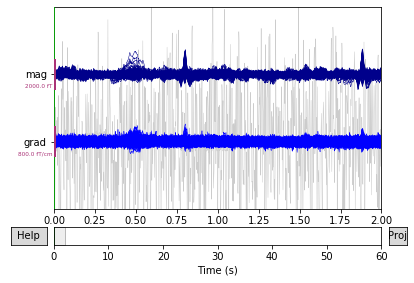

In [14]:
raw.pick(['meg']).plot(duration=2,butterfly=True);

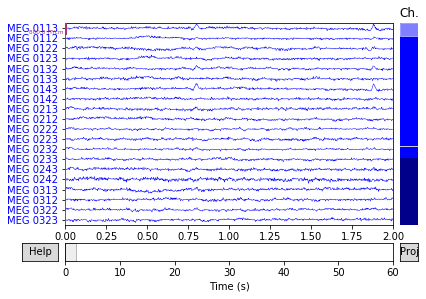

In [17]:
raw.pick(['meg']).plot(duration=2);

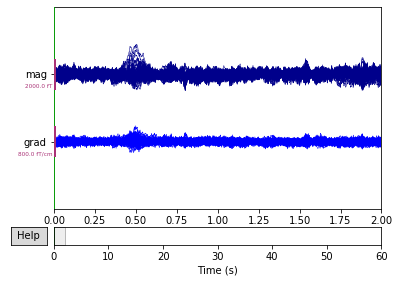

In [15]:
raw_sss.pick(['meg']).plot(duration=2,butterfly=True);

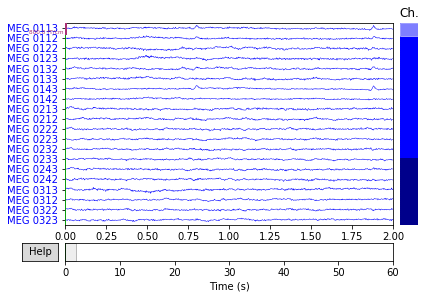

In [18]:
raw_sss.pick(['meg']).plot(duration=2);

- The `maxwell_filter` function has parameters `int_order` and `ext_order` for setting the order of the spherical harmonic expansion of the interior and exterior components;
- The default values are appropriate for most use case;
- Additional parameters include `coord_frame` and `origin` for controlling the coordinate frame("head" or "meg") and the origin of the spheres;
- The defaults are appropriate for most studies that include digitization of the scalp suface/electrodes.
------


#### Spatiotemporal SSS(tSSS)
- An assumption of SSS is that the measurement volume (the spherical shell where the sensors are physically located) is free of electromagnetic sources.
- The thickness of this source-free measurement shell should be 4-8 cm for SSS to perform optimally.
- **In Practice, there may be sources falling within that measurement volume, these can often be mitigated by using Spatiotemporal Signal Separation (tSSS).**
- **tSSS works by looking for temporal correlation between components of the internal and external subpaces.** The projection is done in an analogous way to SSP, **except that the noise vector is computed across time points instead of acrross sensors.**

为了使用tSSS，即使用`maxwell_filter()`时，需要传递时间（秒）参数给 `st_duration`，用于指定计算时间投影的块持续时间（chunk duration）。块持续时间作为一个截止频率为 $1/𝚜𝚝\_𝚍𝚞𝚛𝚊𝚝𝚒𝚘𝚗$ Hz的高通滤波器；

- 通常下，`st_duration`越大越好，值越大对信号的影响也会越小；当然，会消耗更多的内存；
- `st_only`是指使用时间投影，不使用SSS和Maxwell filtering。

Maxwell filtering raw data
    Using loaded raw data
    Bad MEG channels being reconstructed: ['MEG 2443', 'MEG 1032', 'MEG 2323']
    Processing 204 gradiometers and 102 magnetometers
    Using origin 0.0, 0.0, 0.0 mm in the head frame
    Processing data using tSSS with st_duration=9.999750418577312
    Spatiotemporal window did not fit evenly intocontiguous data segment. 0.00 seconds were lumped into the previous window.
        Using 71/95 harmonic components for    0.000  (56/80 in, 15/15 out)
    Processing 6 data chunks
        Projecting  0 intersecting tSSS components for    0.000 -    9.998 sec (#1/6)
        Projecting  0 intersecting tSSS components for   10.000 -   19.998 sec (#2/6)
        Projecting  0 intersecting tSSS components for   20.000 -   29.998 sec (#3/6)
        Projecting  0 intersecting tSSS components for   29.999 -   39.997 sec (#4/6)
        Projecting  0 intersecting tSSS components for   39.999 -   49.997 sec (#5/6)
        Projecting  0 intersecting t

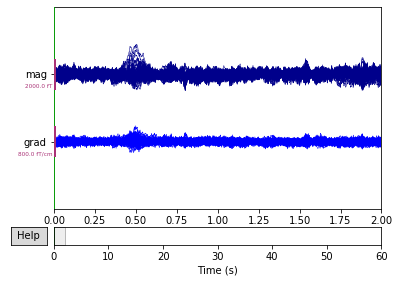

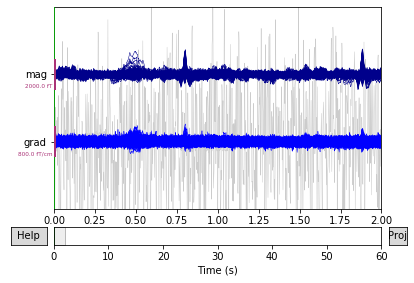

In [23]:
# must un-do software compensation firtst
raw.apply_gradient_compensation(0) 
# origin: origin of internal and external multipolar moment space in meters,
# The default is 'auto',which means (0.,0.,0.),when coord_frame='meg'
mf_kwargs = dict(origin=(0.,0.,0.),st_duration=10.)
raw_tsss = mne.preprocessing.maxwell_filter(raw,**mf_kwargs)

raw_sss.pick(['meg']).plot(duration=2,butterfly=True);
raw.pick(['meg']).plot(duration=2,butterfly=True);

#### Movement compensation
- If you have information about subject head position relative to the sensors,i.e. continuous head position indicator coils,or cHPI,`.pos` file;
- SSS can take that into account when projecting sensor data onto the internal subpace. 
- Head position data is loaded with the `read_head_pos()` function. 
- The cHPI data file could also be passed as the `head_pos` parameter of `maxwell_filter()`. 

In [ ]:
head_pos_file = os.path.join(mne.datasets.testing.data_path(),'SSS','test_move_anon_raw.pos')
head_pos = mne.chpi.read_head_pos(head_pos_file)
mne.viz.plot_head_positions(head_pos,mode='traces');

#### 使用SSS/Maxwell filtering的注意事项
- Maxwell filtering专利限制算法商业使用;
- SSS works best when both magnetometers and gradiometers are present, and is most effective when gradiometers are planar (due to the need for very accurate sensor geometry and fine calibration information). Thus its performance is dependent on the MEG system used to collect the data.

Various Maxwell filtering algorithm components are covered by patents owned by MEGIN. These patents include, but may not be limited to:

US2006031038 (Signal Space Separation)

US6876196 (Head position determination)

WO2005067789 (DC fields)

WO2005078467 (MaxShield)

WO2006114473 (Temporal Signal Space Separation)

These patents likely preclude the use of Maxwell filtering code in commercial applications. Consult a lawyer if necessary.

Ref:
- [Signal-space separation(SSS) and Maxwell filtering](https://mne.tools/stable/auto_tutorials/preprocessing/plot_60_maxwell_filtering_sss.html#sphx-glr-auto-tutorials-preprocessing-plot-60-maxwell-filtering-sss-py)
- [Maxwell filter data with movement compensation](https://mne.tools/stable/auto_examples/preprocessing/plot_movement_compensation.html?highlight=maxwell)
- [MNE-python Maxwell filtering source code](https://github.com/mne-tools/mne-python/blob/master/mne/preprocessing/maxwell.py)
- [tSSS example](https://mne.tools/stable/auto_tutorials/sample-datasets/plot_brainstorm_phantom_ctf.html#sphx-glr-auto-tutorials-sample-datasets-plot-brainstorm-phantom-ctf-py)
- [Maxwell filter using MNE-python](https://mne.tools/mne-biomag-group-demo/auto_scripts/03-maxwell_filtering.html#sphx-glr-auto-scripts-03-maxwell-filtering-py)
- [Movement compensation of CTF data by Maxwell filtering *without* external interference suppression?](https://github.com/mne-tools/mne-python/issues/5960)
- [temporal filtering before maxwell filtering?](https://github.com/mne-tools/mne-study-template/issues/59)
- [mne study template](https://github.com/mne-tools/mne-study-template/commit/e60587f030316848db56a66828c865f27b2bba19)
- [Analysis for one subject with tSSS](https://mne.tools/mne-bioma%C3%A5-group-demo/auto_examples/demos/plot_tsss_analysis.html)